<a href="https://colab.research.google.com/github/seungyihong/dacon_AI_Frenz/blob/master/TestMLModelCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#@title 현재 경로명 입력
#@markdown /My Drive/ [ **any directory you use** ]
Directory = "Dacon/\uC628\uB3C4 \uCD94\uC815" #@param {type:"string"}

currDir = '/content/drive/My Drive/' + Directory
#현재 코드가 실행되는 디렉토리명
print("현재 경로:", currDir)

현재 경로: /content/drive/My Drive/Dacon/온도 추정


In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import multiprocessing
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import seaborn as sns
import os
from sklearn.feature_selection import VarianceThreshold # 특성 공학
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split

#경고 에러 무시
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


In [0]:
def MakeXData515(X_train_, X_test_):
  '''
  개인적판단 데이터셋
  '''
  # X_train 데이터 중 분산이 낮은 특성 제거
  select_VT = VarianceThreshold(1e-5)
  select_VT.fit(X_train_)

  removedFeature = X_train_.columns[~select_VT.get_support()]

  # 제거된 특성은 일일 누적일사량, 모든 값이 0인 것으로 확인.
  X_train_.drop(removedFeature, axis=1, inplace=True)
  X_test_.drop(removedFeature, axis=1, inplace=True)

  # 남은 누적일사량 X11, X34는 분포가 같고, 값의 크기 차이가 적다. 평균내서 단일 특성으로 활용하자.
  X_train_['SUN'] = X_train_[['X11','X34']].mean(axis=1)
  X_test_['SUN'] = X_test_[['X11','X34']].mean(axis=1)
  X_train_.drop(['X11','X34'], axis=1, inplace=True)
  X_test_.drop(['X11','X34'], axis=1, inplace=True)

  # 기압은 시각화해보면 분포가 거의 같다. 현지기압만 평균내서 단일 특성으로 활용하자.
  X_train_['PRESS'] = X_train_[localpress_name].mean(axis=1)
  X_test_['PRESS'] = X_test_[localpress_name].mean(axis=1)
  X_train_.drop(localpress_name, axis=1, inplace=True)
  X_test_.drop(localpress_name, axis=1, inplace=True)
  X_train_.drop(press_name, axis=1, inplace=True)
  X_test_.drop(press_name, axis=1, inplace=True)

  # 풍속, 풍향은 시각화하면 기온과의 선형 관계성이 떨어진다. 삭제
  X_train_.drop(speed_name, axis=1, inplace=True)
  X_test_.drop(speed_name, axis=1, inplace=True)
  X_train_.drop(direction_name, axis=1, inplace=True)
  X_test_.drop(direction_name, axis=1, inplace=True)

  # 기온의 분포가 거의 같아서 평균 내어 temp 특성으로 사용
  X_train_['TEMP'] = X_train_[temperature_name].mean(axis=1)
  X_test_['TEMP'] = X_test_[temperature_name].mean(axis=1)
  X_train_.drop(temperature_name, axis=1, inplace=True)
  X_test_.drop(temperature_name, axis=1, inplace=True)

  # 강수량, 습도도 평균내서 사용
  X_train_['WATER'] = X_train_[water_name].mean(axis=1)
  X_test_['WATER'] = X_test_[water_name].mean(axis=1)
  X_train_.drop(water_name, axis=1, inplace=True)
  X_test_.drop(water_name, axis=1, inplace=True)
  X_train_['HUMID'] = X_train_[humidity_name].mean(axis=1)
  X_test_['HUMID'] = X_test_[humidity_name].mean(axis=1)
  X_train_.drop(humidity_name, axis=1, inplace=True)
  X_test_.drop(humidity_name, axis=1, inplace=True)
  
  return X_train_, X_test_

def MakeXDataMean(X_train_, X_test_):
  X_train_['SUN'] = X_train_[['X11','X34']].mean(axis=1)
  X_test_['SUN'] = X_test_[['X11','X34']].mean(axis=1)
  X_train_['PRESS'] = X_train_[localpress_name].mean(axis=1)
  X_test_['PRESS'] = X_test_[localpress_name].mean(axis=1)
  X_train_['TEMP'] = X_train_[temperature_name].mean(axis=1)
  X_test_['TEMP'] = X_test_[temperature_name].mean(axis=1)
  X_train_['WATER'] = X_train_[water_name].mean(axis=1)
  X_test_['WATER'] = X_test_[water_name].mean(axis=1)
  X_train_['HUMID'] = X_train_[humidity_name].mean(axis=1)
  X_test_['HUMID'] = X_test_[humidity_name].mean(axis=1)
  X_train_['SPEED'] = X_train_[speed_name].mean(axis=1)
  X_test_['SPEED'] = X_test_[speed_name].mean(axis=1)

  return X_train_, X_test_

def MakeyData515(y_train_):
  '''
  개인적판단 데이터셋
  '''
  # 상관관계 낮은 행 삭제
  y_train_.drop(['Y03', 'Y04'], axis=1, inplace=True)

  # 평균값으로 Y18 대체
  y_train_.loc[y_train_[y_train_['Y18'].isna() == True].index, 'Y18'] = y_train_[y_train_.columns].mean(axis=1)
  y_train_ = pd.DataFrame(y_train_.loc[:,'Y18'])

  return y_train_

def Scaler(X_train_, X_test_, mode='minmax'):
  '''
  Standard 또는 Minmax Sclaer 적용
  '''
  if mode == 'standard':
    MEAN = X_train.mean()
    STD  = X_train.std()
    X_train_ = (X_train_ - MEAN) / (STD + 1e-07)
    X_test_  = (X_test_  - MEAN) / (STD + 1e-07)
    print('standard scaling complete...'); print('-'*50)

  elif mode == 'minmax':
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    for col_ in X_train_.columns:
      train_scaled = scaler.fit_transform(X_train_[col_][:, np.newaxis])
      test_scaled = scaler.transform(X_test_[col_][:, np.newaxis])
      X_train_[col_] = train_scaled.flatten()
      X_test_[col_] = test_scaled.flatten()
    print('minmax scaling complete...'); print('-'*50)
  print('X_train:\n',X_train_.head()); print('-'*50)
  print('X_test:\n',X_test_.head()); print('-'*50)
  return X_train_, X_test_

def mse_keras(y_true, y_pred):
  '''
  # Metric define
  '''
  def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

  score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32, name='custom_mse') # tf 2.x
  #score = tf.py_func( lambda y_true, y_pred : mse_AIFrenz(y_true, y_pred) , [y_true, y_pred], 'float32', stateful = False, name = 'custom_mse' ) # tf 1.x
  return score

def testplot(Model):
  X_submit = X_traintest.iloc[144*33:,:]
  y_pred = Model.predict(X_submit)
  a = y_pred.flatten() # 80일
  b = train_origin.loc[144*30:144*33,'Y18'].values # 3일

  plt.figure(figsize=(30,10))
  plt.plot(np.hstack([b,a])) # 3+80일
  plt.plot(np.hstack([train_origin.loc[144*30:144*33,'X07'], test_origin.loc[:,'X07']]))
  plt.axvline(x=144*3, color='g', linestyle='--', linewidth=2)
  plt.show()
  return y_pred

def mse_AIFrenz_gbm(y_true, y_pred):
    '''
    y_true: 실제 값
    y_pred: 예측 값
    '''
    diff = abs(y_true - y_pred)
    
    less_then_one = np.where(diff < 1, 0, diff)
    
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return ('mse_AIFrenz', score, False)
    
def mse_AIFrenz(y_true, y_pred):
    '''
    y_true: 실제 값
    y_pred: 예측 값
    '''
    diff = abs(y_true - y_pred)
    
    less_then_one = np.where(diff < 1, 0, diff)
    
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    score = np.average(np.average(less_then_one ** 2, axis = 0))
    
    return score

'''강수량 처리 모듈 추가해서 아래 과정 진행'''
def water_transformer(water_array):
  beforewater = 0
  currwater = 0
  water_trans_list = []
  for accumwater in water_array:
    if beforewater < accumwater:
      # print('상승')
      currwater = accumwater - beforewater
      # print('축적강수량: {}, 이전강수량: {}, 순간강수량: {}'.format(accumwater, beforewater, currwater))
      beforewater = accumwater
    elif beforewater >= accumwater:
      # print('==')
      temp = currwater*0.9
      if temp < 0.05:
        currwater = 0
      else: currwater = temp
      # print('축적강수량: {}, 이전강수량: {}, 순간강수량: {}'.format(accumwater, beforewater, currwater))
      beforewater = accumwater
    water_trans_list.append(currwater)
  return water_trans_list

def sun_transformer(sun_array):
  beforesun = 0
  currsun = 0
  sun_trans_list = []
  for accumsun in sun_array:
    if beforesun < accumsun:
      currsun = accumsun - beforesun
      beforesun = accumsun
    elif beforesun >= accumsun:
      temp = currsun*0.95
      if temp < 0.05:
        currsun = 0
      else: currsun = temp
      beforesun = accumsun
    sun_trans_list.append(currsun)
  return sun_trans_list

from sklearn.metrics import make_scorer
score_metric = make_scorer(mse_AIFrenz, greater_is_better=False)
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [0]:
np.random.seed(7)
random.seed(7)
print('Random seed set'); print('-'*50)

train = pd.read_csv(currDir + '/input/train.csv', index_col = 'id')
test = pd.read_csv(currDir + '/input/test.csv', index_col = 'id')
print('Data: train / test set'); print('-'*50)

# 데이터 정보
temperature_name = ["X00","X07","X28","X31","X32"] #기온
localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
speed_name       = ["X02","X03","X18","X24","X26"] #풍속
water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
press_name       = ["X05","X08","X09","X23","X33"] #해면기압
sun_name         = ["X11","X14","X16","X19","X34"] #일일 누적일사량
humidity_name    = ["X12","X20","X30","X37","X38"] #습도
direction_name   = ["X13","X15","X17","X25","X35"] #풍향

'''사용할 피쳐 정의해서 사용'''
SELECT_TEMP_COL_LIST  = ['X00', 'X31', 'X32']
SELECT_HUMID_COL_LIST = ['X30', 'X37', 'X38']
SELECT_SUN_COL_LIST   = ['X11']
TEST_COL_LIST         = ["X18","X24","X26"]
USE_COL_LIST          = SELECT_TEMP_COL_LIST + SELECT_HUMID_COL_LIST + SELECT_SUN_COL_LIST 
# USE_COL_LIST          = temperature_name + localpress_name + speed_name + water_name + press_name + humidity_name + direction_name + ['X11', 'X34']
print(USE_COL_LIST)

X_train = train.loc[:, USE_COL_LIST].copy()
X_test = test.loc[:, USE_COL_LIST].copy()

'''시간대 특성 추가'''
X_train['TIME'] = (train.index)%144
X_test['TIME'] = (test.index)%144

'''SELECT_TEMP_COL_LIST를 이용한 TRAIN_TEMP_MEAN , TEST_TEMP_MEAN 생성'''
TRAIN_TEMP_MEAN = X_train[SELECT_TEMP_COL_LIST].mean(axis=1)
TEST_TEMP_MEAN  = X_test[SELECT_TEMP_COL_LIST].mean(axis=1)

'''워터 영향력 전파'''
for water_col_ in water_name:
  water_trans_list_ = water_transformer(X_train[water_col_].values)
  X_train[water_col_] = water_trans_list_
  water_trans_list_ = water_transformer(X_test[water_col_].values)
  X_test[water_col_] = water_trans_list_

'''일사량 영향력 전파'''
for sun_col_ in ['X11']:
  sun_trans_list_ = sun_transformer(X_train[sun_col_].values)
  X_train[sun_col_] = sun_trans_list_
  sun_trans_list_ = sun_transformer(X_test[sun_col_].values)
  X_test[sun_col_] = sun_trans_list_

'''스케일링 처리'''
X_train_norm, X_test_norm = Scaler(X_train, X_test, mode='standard')

'''y_train 세팅'''
USE_y_list = ['Y06'] # 스케일 잘따라함
# USE_y_list = ['Y07'] # 마찬가지 인상깊네
# USE_y_list = ['Y06']
y_train = train.loc[:, USE_y_list+['Y18']].copy()
y_train.loc[:144*30-1, 'Y18'] = y_train.loc[:144*30-1, USE_y_list[0]]
y_train.drop(USE_y_list, axis=1, inplace=True)

X_train_norm.shape, X_test_norm.shape, y_train.shape

Random seed set
--------------------------------------------------
Data: train / test set
--------------------------------------------------
['X00', 'X31', 'X32', 'X30', 'X37', 'X38', 'X11', 'X04', 'X10', 'X21', 'X36', 'X39']
standard scaling complete...
--------------------------------------------------
X_train:
          X00       X31       X32  ...       X36       X39      TIME
id                                ...                              
0  -2.236377 -2.109779 -1.766623  ... -0.134411 -0.200918 -1.719883
1  -2.321347 -2.091664 -1.842501  ... -0.134411 -0.200918 -1.695829
2  -2.300105 -2.146009 -1.956318  ... -0.134411 -0.200918 -1.671775
3  -2.300105 -2.200355 -2.013226  ... -0.134411 -0.200918 -1.647720
4  -2.342589 -2.254700 -2.013226  ... -0.134411 -0.200918 -1.623666

[5 rows x 13 columns]
--------------------------------------------------
X_test:
            X00       X31       X32  ...       X36       X39      TIME
id                                  ...                

((4752, 13), (11520, 13), (4752, 1))

In [0]:
X_train

,X00,X31,X32,X30,X37,X38,X11,X04,X10,X21,X36,X39,TIME
id,,,,,,,,,,,,,
0,9.7,8.2,10.7,69.1,77.2,62.6,0.0,0.0,0.000000,0.000000,0.0,0.0,0
1,9.3,8.3,10.3,70.3,77.3,63.5,0.0,0.0,0.000000,0.000000,0.0,0.0,1
2,9.4,8.0,9.7,71.5,77.3,63.9,0.0,0.0,0.000000,0.000000,0.0,0.0,2
3,9.4,7.7,9.4,73.2,77.5,64.5,0.0,0.0,0.000000,0.000000,0.0,0.0,3
4,9.2,7.4,9.4,74.3,78.0,65.0,0.0,0.0,0.000000,0.000000,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,17.7,19.1,89.9,82.3,58.6,0.0,0.0,0.067543,0.193710,0.0,0.0,139
4748,19.9,17.7,19.2,91.3,82.5,59.1,0.0,0.0,0.060788,0.174339,0.0,0.0,140
4749,19.7,17.8,19.2,90.2,83.0,58.9,0.0,0.0,0.054709,0.156905,0.0,0.0,141


(4752, 13) (4752, 1)
0.9983319710687812
0.9853116877402854


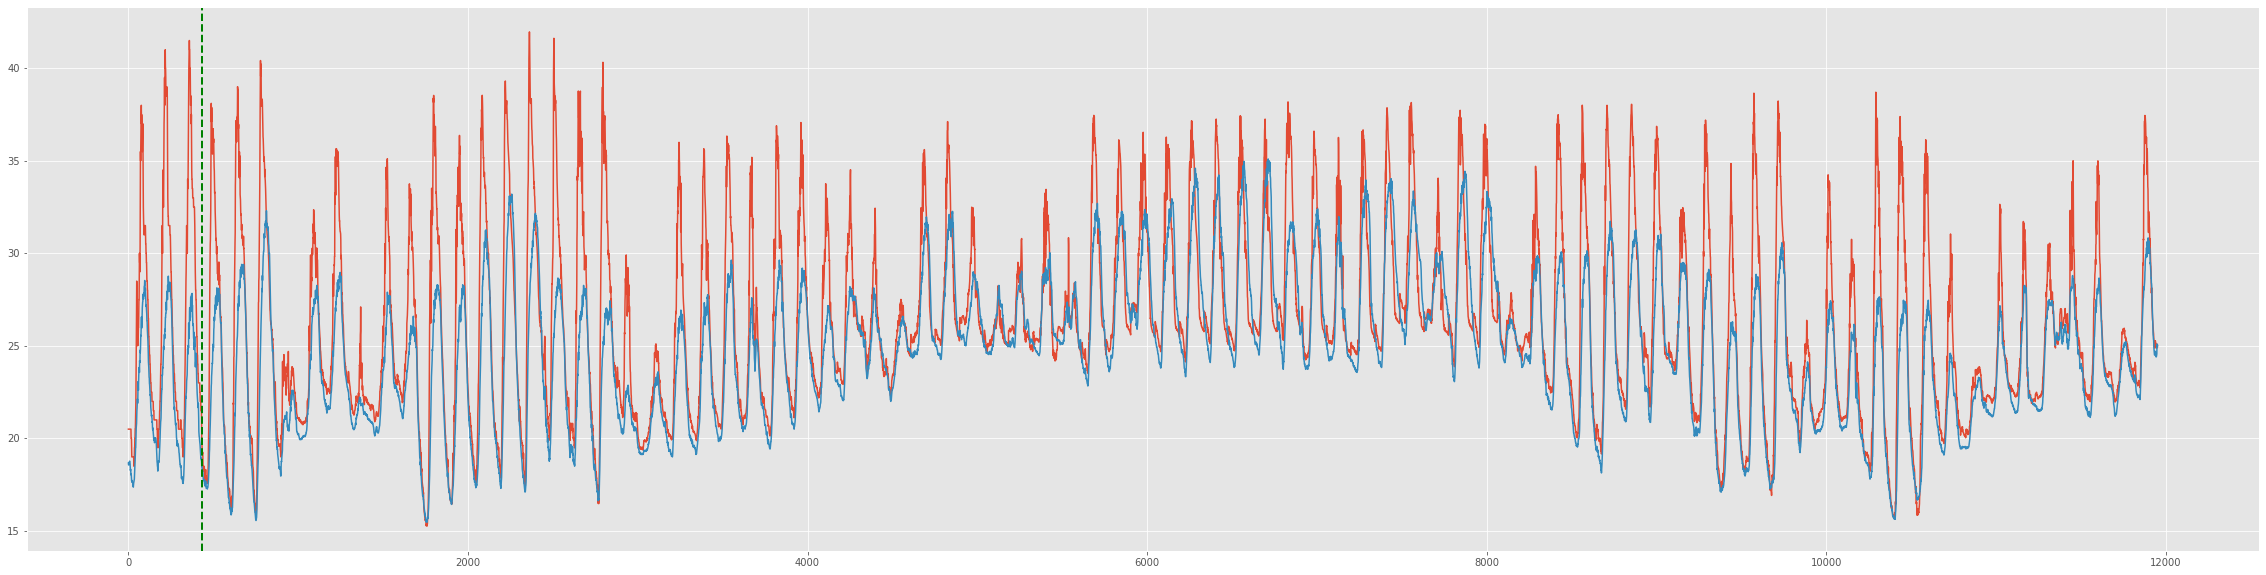

In [0]:
'''y_train_mean으로 33일 학습'''
%matplotlib inline
X = X_train_norm
y = y_train
print(X.shape, y.shape)

x_train_, x_test_, y_train_, y_test_ = train_test_split(X, y,
                                                    random_state = 42, 
                                                    test_size = 0.3,
                                                    shuffle = True)

model = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=2000, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

# model = lgb.LGBMRegressor(random_state=42)

model.fit(x_train_, y_train_)
print(model.score(x_train_,y_train_))
print(model.score(x_test_,y_test_))

X_submit = X_test_norm
y_pred = model.predict(X_submit)
a = y_pred.flatten() # 80일
b = train.loc[144*30:144*33,'Y18'].values # 3일

plt.figure(figsize=(40,10))
plt.plot(np.hstack([b,a])) # 3+80일
plt.plot(np.hstack([TRAIN_TEMP_MEAN[144*30:], TEST_TEMP_MEAN]))
plt.axvline(x=144*3, color='g', linestyle='--', linewidth=2)
plt.show()

In [0]:
# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':y_pred.reshape(1,-1)[0]})

submit.to_csv(currDir + '/submit/baseline_result0.csv', index = False)

## 그리드 서치로 최적 파라미터 찾기

In [0]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
etf_param = {
              'n_estimators'      : [9999],
              'max_features'      : [25],
              'min_samples_leaf'  : [2],
              'min_samples_split' : [50],
              'bootstrap'         : [False],
            } 
# min_samples_leaf 는 50보다 크게 해보자
# n_estimator는 사실 클 수록 좋지 않나

etf_model = ExtraTreesRegressor(n_jobs = -1, random_state=42)

# etf_grid_search = RandomizedSearchCV(
#                           estimator = etf_model,
#                           param_distributions = etf_param,
#                           n_iter = 100,
#                           # cv = 5,
#                           # scoring = score_metric,
#                           scoring = 'r2'
#                           )

etf_grid_search = GridSearchCV(estimator = etf_model,
                           param_grid = etf_param,
                          #  cv = 5,
                           scoring = score_metric,
                          #  scoring = 'r2',
                           return_train_score = True)

etf_grid_search.fit(X,y)

# 최적 파라미터 찾고
print('best param:', etf_grid_search.best_params_); print('-'*50)
print('best score:', etf_grid_search.best_score_); print('-'*50)
# 한번 확인해주고
paramset = etf_grid_search.cv_results_["params"]
meantestscore = etf_grid_search.cv_results_["mean_test_score"]
result_ = pd.DataFrame({'params': paramset, 'score': meantestscore})
result_.sort_values('score', ascending=False, inplace=True)
print(result_.head(5)); print('-'*50)
print(result_['params'].values[:10]); print('-'*50)

In [0]:
# 그걸로 전체 학습하고
etf_model = etf_grid_search.best_estimator_
etf_model.fit(X,y)

In [0]:
y_pred = testplot(Model=etf_model)

## RFE로 좋은 특성 조합 찾기

In [0]:
from sklearn.feature_selection import RFE
etf_model = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.6, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=50, min_weight_fraction_leaf=0.0,
                    n_estimators=800, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)
select_RFE = RFE(etf_model, n_features_to_select=3)
X_train = select_RFE.fit_transform(X, y)
X_train.shape

In [0]:
etf_model.fit(X_train, y)

In [0]:
X_submit = X_traintest.iloc[144*33:,:]
X_submit_RFE = select_RFE.transform(X_submit)
y_pred = etf_model.predict(X_submit_RFE)
a = y_pred.flatten() # 80일
b = train_origin.loc[144*30:144*33,'Y18'].values # 3일

plt.figure(figsize=(30,10))
plt.plot(np.hstack([b,a])) # 3+80일
plt.plot(np.hstack([train_origin.loc[144*30:144*33,'X07'], test_origin.loc[:,'X07']]))
plt.axvline(x=144*3, color='g', linestyle='--', linewidth=2)
plt.show()

In [0]:
# 7 27
for i in range(28,38):
  etf_model = ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=0.6, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=2,
                    min_samples_split=50, min_weight_fraction_leaf=0.0,
                    n_estimators=800, n_jobs=-1, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)
  select_RFE = RFE(etf_model, n_features_to_select=i)
  X_train = select_RFE.fit_transform(X, y)
  etf_model.fit(X_train, y)
  X_submit = X_traintest.iloc[144*33:,:]
  X_submit_RFE = select_RFE.transform(X_submit)
  y_pred = etf_model.predict(X_submit_RFE)
  a = y_pred.flatten() # 80일
  b = train_origin.loc[144*30:144*33,'Y18'].values # 3일
  print('-'*50)
  print(i)
  plt.figure(figsize=(30,10))
  plt.plot(np.hstack([b,a])) # 3+80일
  plt.plot(np.hstack([train_origin.loc[144*30:144*33,'X07'], test_origin.loc[:,'X07']]))
  plt.axvline(x=144*3, color='g', linestyle='--', linewidth=2)
  plt.show()